In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time

from draw_strokes import draw_strokes

from experiment import run_epoch
from lstm import LSTMGenerator, LSTMDiscriminator
from lstm_data import LSTMDataset, create_mask, create_batch_mask, revert

DATA_PATH = "sheep_market.npz"
data = np.load(DATA_PATH, allow_pickle=True, encoding="bytes")
train_raw_data = data["train"]
valid_raw_data = data["valid"]
test_raw_data = data["test"]

MEAN = [0.3776045376257754, 0.30774983488947305]
STD = [21.851689358105794, 14.4384627726713]


In [2]:
DIM = 4
H_DIM = 16
LAYERS = 4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 0 if DEVICE == "cpu" else 2

generator = LSTMGenerator(h_dim=H_DIM, dim=DIM, num_layers=LAYERS)
discriminator = LSTMDiscriminator(h_dim=H_DIM, dim=DIM, num_layers=LAYERS)

generator.to(DEVICE)
discriminator.to(DEVICE)
    
train = LSTMDataset(train_raw_data, MEAN, STD)
valid = LSTMDataset(valid_raw_data, MEAN, STD)
test = LSTMDataset(test_raw_data, MEAN, STD)


LSTMGenerator(
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (sequential): SequentialModule(
    (sequential): Sequential(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=64, out_features=4, bias=True)
    )
  )
)


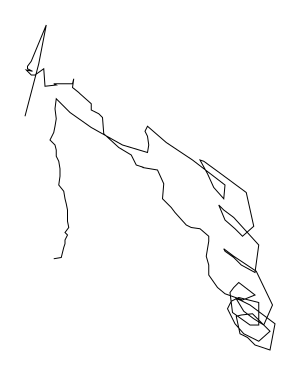

In [108]:
GENERATOR_PATH = "../results/gen-950.pth"
DIM = 4
H_DIM = 256
LAYERS = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

generator = LSTMGenerator(h_dim=H_DIM, dim=DIM, num_layers=LAYERS)
print(generator)
generator.load(GENERATOR_PATH)


z = torch.normal(torch.zeros(1, 141, H_DIM), 1) # B, H
gen = generator(z)
gen = revert(gen, MEAN, STD)
# print(gen)

draw_strokes(gen)


92


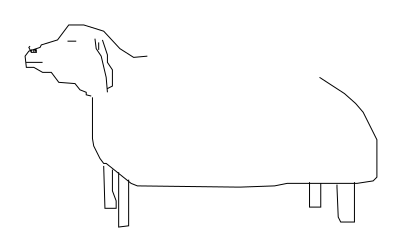

In [5]:
ITEM = 10
raw = train_raw_data[ITEM]
print(len(raw))
draw_strokes(raw)


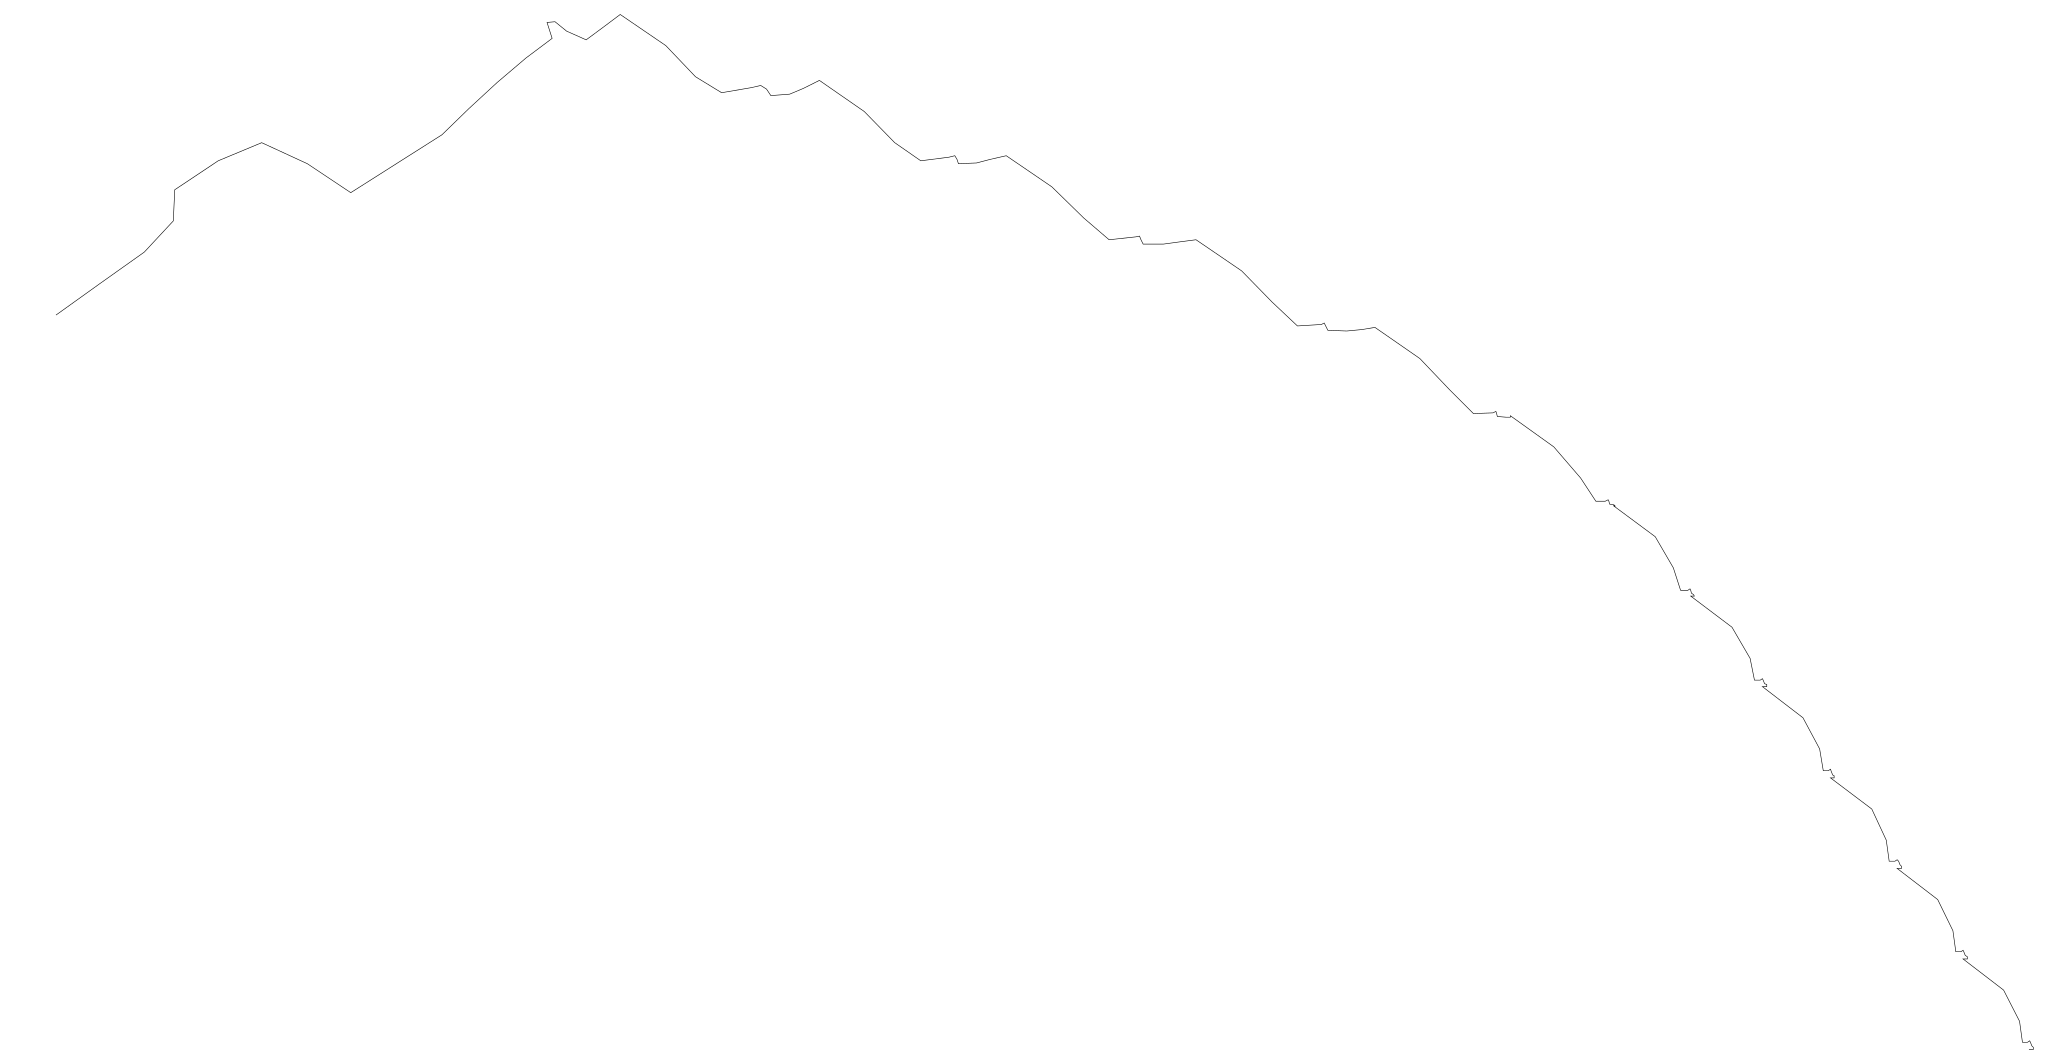

In [101]:
with open("sheep2.txt", "r") as f:
    text_data = f.read()
text_data = text_data.replace(" ", ",")

data_array = np.array(eval(text_data))
draw_strokes(data_array)


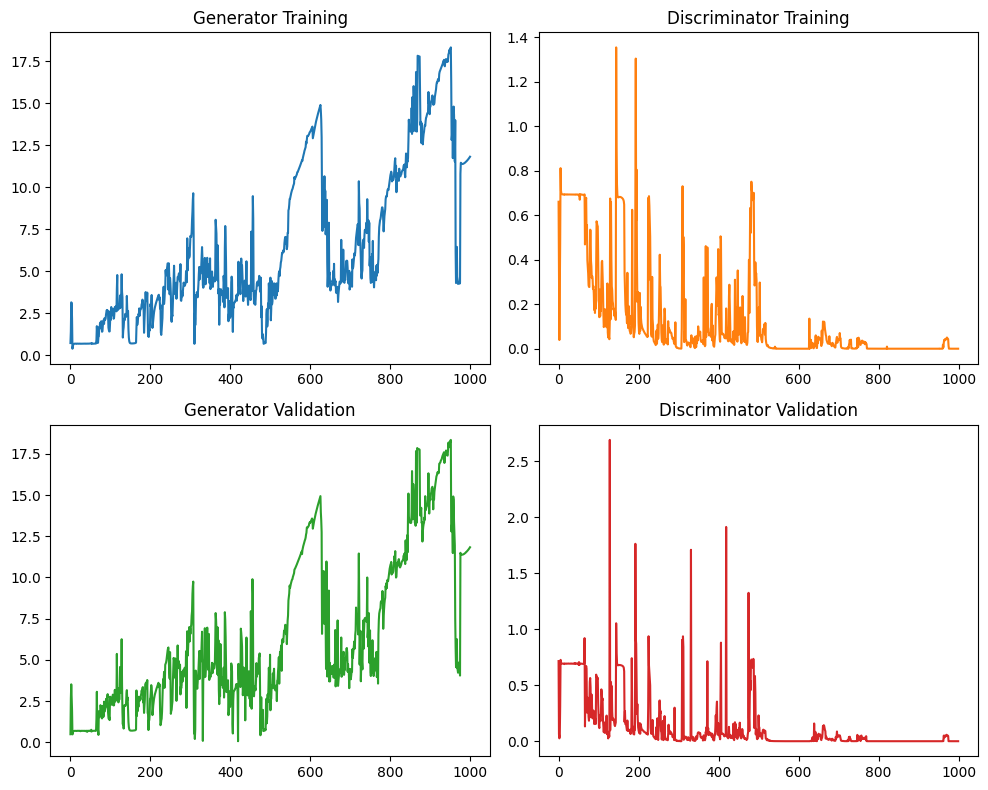

In [11]:
import pickle
import matplotlib.pyplot as plt
with open("../results_1000.pkl", "rb") as f:
    results = pickle.load(f, encoding="bytes")

EPOCHS = 1000
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(np.arange(EPOCHS), results["train_gen_loss"], 'tab:blue')
axs[0, 0].set_title('Generator Training')

# Second plot
axs[0, 1].plot(np.arange(EPOCHS), results["train_dis_loss"], 'tab:orange')
axs[0, 1].set_title('Discriminator Training')

# Third plot
axs[1, 0].plot(np.arange(EPOCHS), results["val_gen_loss"], 'tab:green')
axs[1, 0].set_title('Generator Validation')

# Fourth plot
axs[1, 1].plot(np.arange(EPOCHS), results["val_dis_loss"], 'tab:red')
axs[1, 1].set_title('Discriminator Validation')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
